### HOUSE SALE PRICING PREDICTION

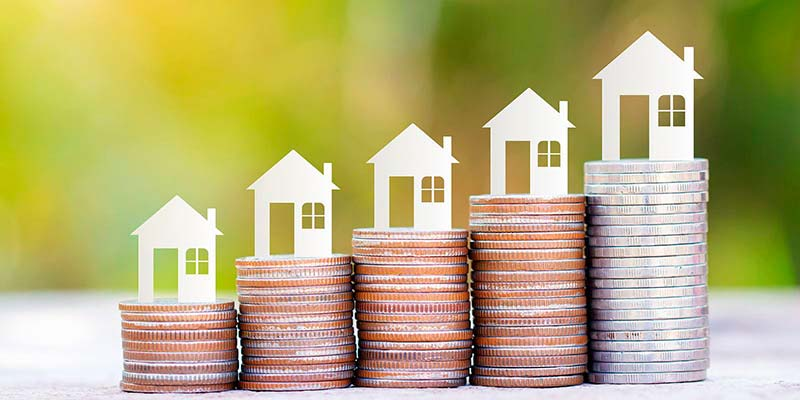

Hi folks! This is a beginners notebook that covers all the main steps necessary to complete a Machine Learning project. Here below you can see a detailed table of contents of the work:

**PREPROCESSING & EDA**

- Importing Libraries & Data
- Dealing with Duplicates and Nan
- Looking at correlations
- Data Normalization (Plots & Tests)


**MODELING**

- Baseline Models with 10-Folds CV
- Best Model (RandomGridSearch)
- Prediction
- Submission

In [1]:
# IMPORTING LIBRARIES & MAIN PATH

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings(action="ignore")

# Defining the working directories

input_path1 = '../input/house-prices-advanced-regression-techniques/'
input_path2 = '../input/ames-housing-dataset/'

In [2]:
# IMPORTING DATA

house_data = pd.read_csv(input_path2 + 'AmesHousing.csv')
test = pd.read_csv(input_path1 + 'test.csv')
data_w = house_data.copy()
data_w.columns = data_w.columns.str.replace(' ', '') # Replacing the white spaces in columns' names
data_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order          2930 non-null   int64  
 1   PID            2930 non-null   int64  
 2   MSSubClass     2930 non-null   int64  
 3   MSZoning       2930 non-null   object 
 4   LotFrontage    2440 non-null   float64
 5   LotArea        2930 non-null   int64  
 6   Street         2930 non-null   object 
 7   Alley          198 non-null    object 
 8   LotShape       2930 non-null   object 
 9   LandContour    2930 non-null   object 
 10  Utilities      2930 non-null   object 
 11  LotConfig      2930 non-null   object 
 12  LandSlope      2930 non-null   object 
 13  Neighborhood   2930 non-null   object 
 14  Condition1     2930 non-null   object 
 15  Condition2     2930 non-null   object 
 16  BldgType       2930 non-null   object 
 17  HouseStyle     2930 non-null   object 
 18  OverallQ

In [3]:
data_w.head()

,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


### EDA & VISUALIZATION

Before working with any kind of data it is important to understand them. A crucial step to this aim is the ***Exploratory data analysis (EDA)***: a combination of visualizations and statistical analysis (uni, bi, and multivariate) that helps us to better understand the data we are working with and to gain insight into their relationships. So, let's explore our target variable and how the other features influence it.

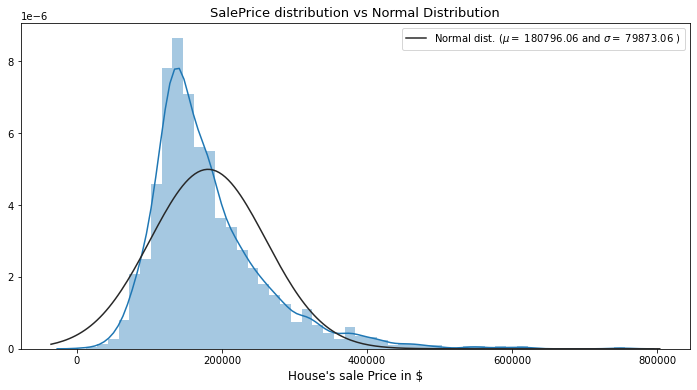

In [4]:
# Getting the main parameters of the Normal Ditribution ()
(mu, sigma) = norm.fit(data_w['SalePrice'])

plt.figure(figsize = (12,6))
sns.distplot(data_w['SalePrice'], kde = True, hist=True, fit = norm)
plt.title('SalePrice distribution vs Normal Distribution', fontsize = 13)
plt.xlabel("House's sale Price in $", fontsize = 12)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.show()

In literature, acceptable values for skewness are between -0.5 and 0.5 while -2 and 2 for Kurtosis. Looking at the plot, we can clearly see how the distribution does not seem to be normal, but highly left-skewed. The non-normality of our distribution is also supported by the Shapiro test for normality (p-value really small that allows us to reject the hypotesis of normality). Despite that, let's leave it like that for now, we'll deal with that later in the notebook. 

In [5]:
# Skew and kurt
from scipy import stats

shap_t,shap_p = stats.shapiro(data_w['SalePrice'])

print("Skewness: %f" % data_w['SalePrice'].skew())
print("Kurtosis: %f" % data_w['SalePrice'].kurt())
print("Shapiro_Test: %f" % shap_t)
print("Shapiro_Test: %f" % shap_p)

Skewness: 1.743500
Kurtosis: 5.118900
Shapiro_Test: 0.876261
Shapiro_Test: 0.000000


The correlation matrix is the best way to see all the numerical correlation between features. Let's see which are the feature that correlate most with our target variable.

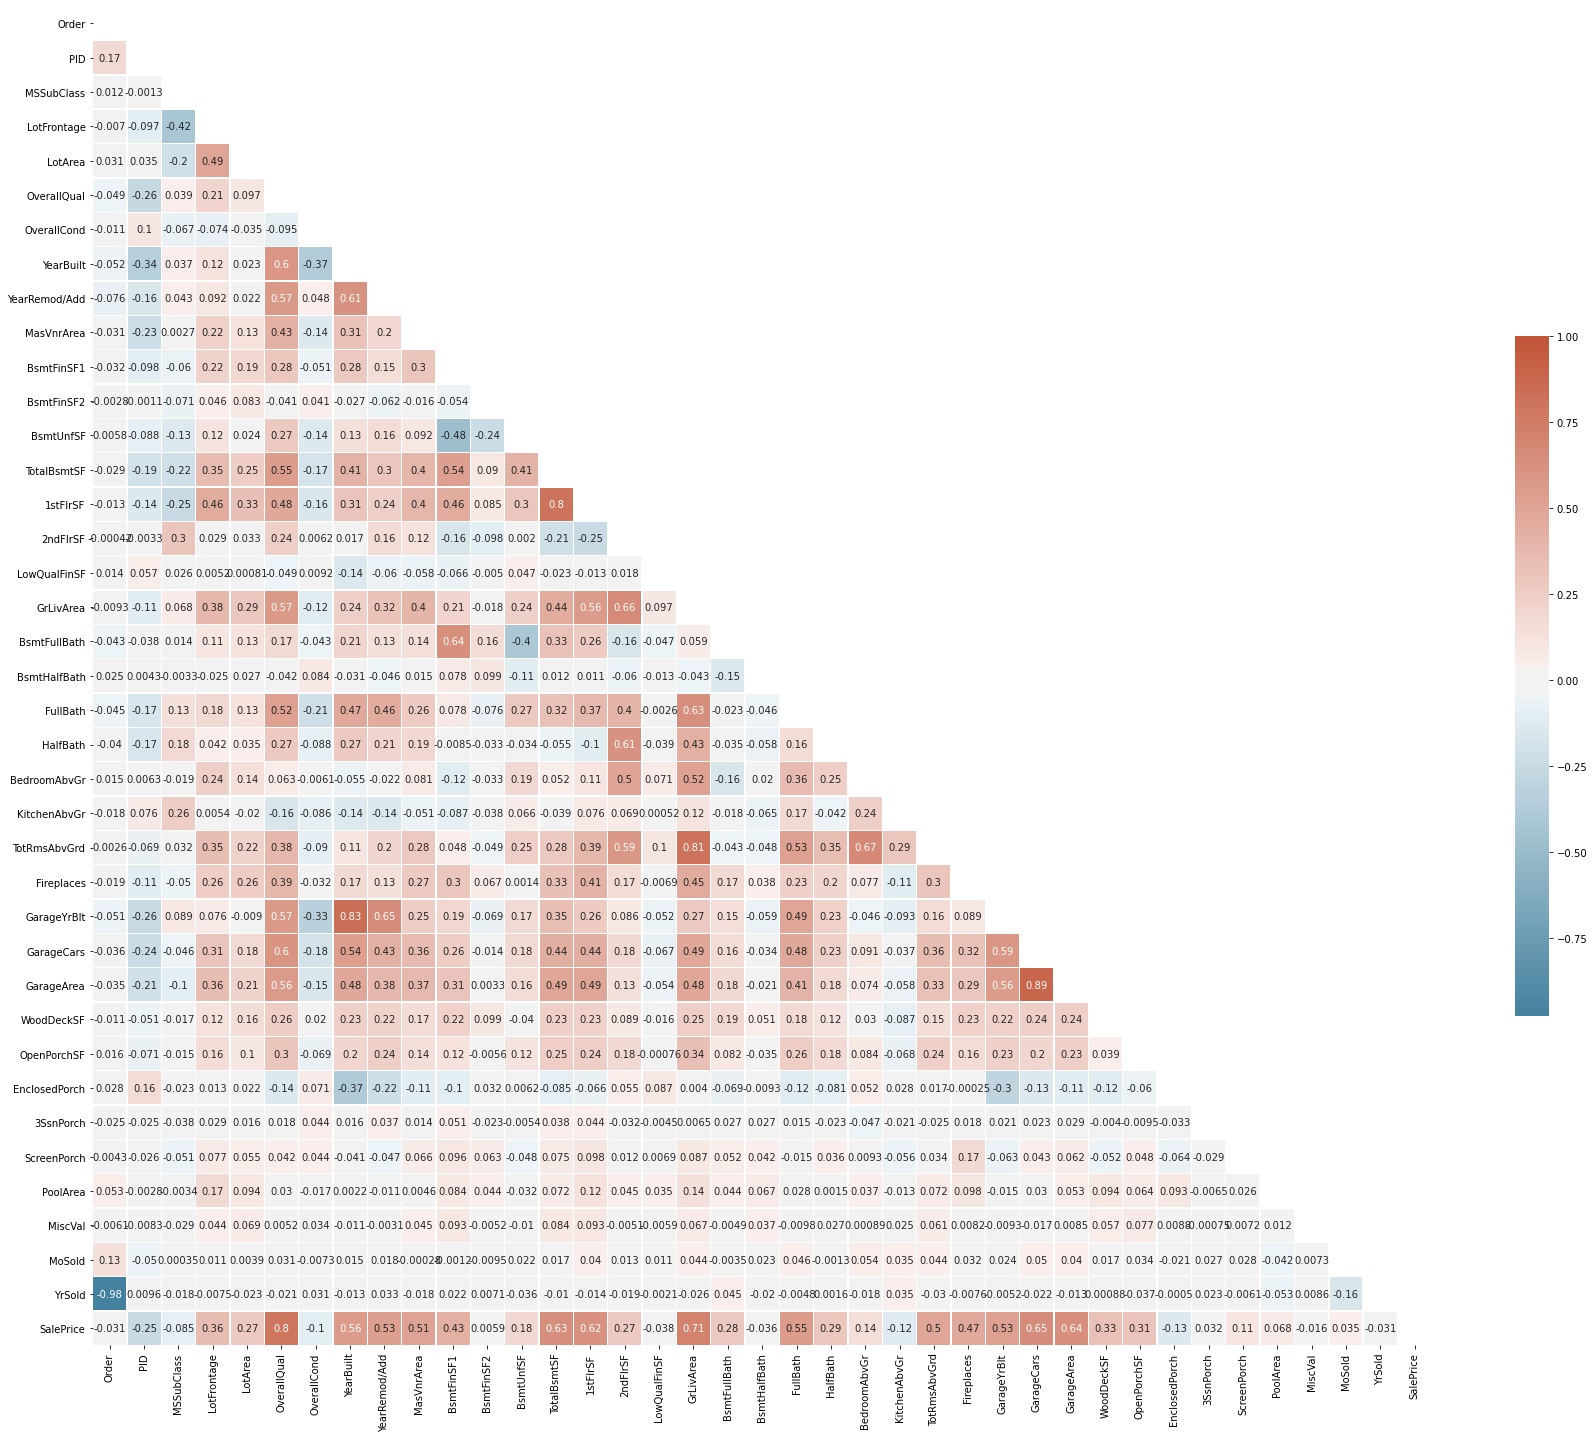

In [6]:
# Correlation Matrix

f, ax = plt.subplots(figsize=(30, 25))
mat = data_w.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Now that we know which features correlates most with our target variable we can investigate them more in depth.

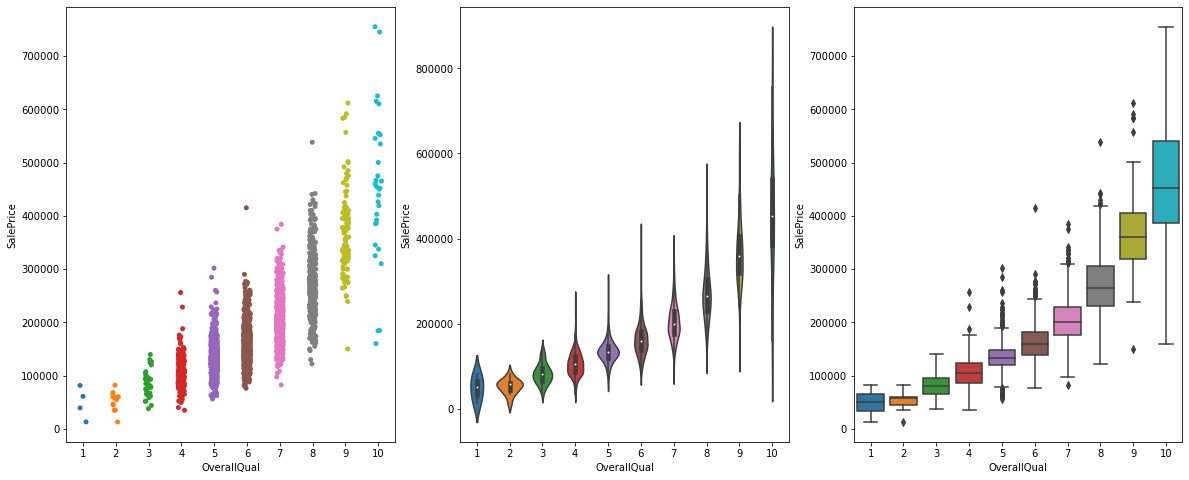

In [7]:
# OverallQuall - SalePrice [Pearson = 0.8]

figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=data_w, x = 'OverallQual', y='SalePrice', ax = ax[0])
sns.violinplot(data=data_w, x = 'OverallQual', y='SalePrice', ax = ax[1])
sns.boxplot(data=data_w, x = 'OverallQual', y='SalePrice', ax = ax[2])
plt.show()

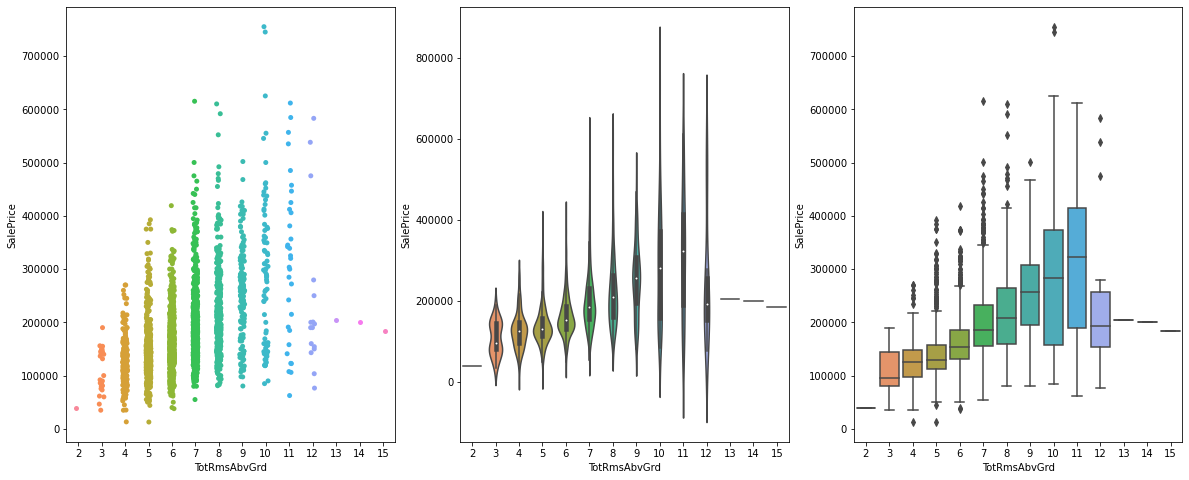

In [8]:
# TotRmsAbvGrd - SalePrice [Pearson = 0.50]

figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=data_w, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[0])
sns.violinplot(data=data_w, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[1])
sns.boxplot(data=data_w, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[2])
plt.show()


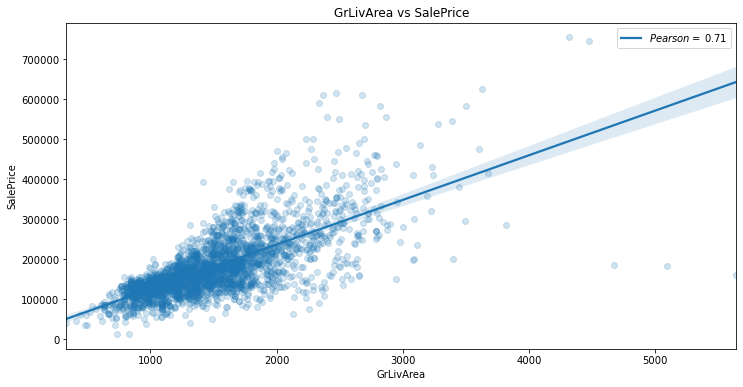

In [9]:
# GrLivArea vs SalePrice [corr = 0.71]

Pearson_GrLiv = 0.71
plt.figure(figsize = (12,6))
sns.regplot(data=data_w, x = 'GrLivArea', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('GrLivArea vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_GrLiv)], loc = 'best')
plt.show()

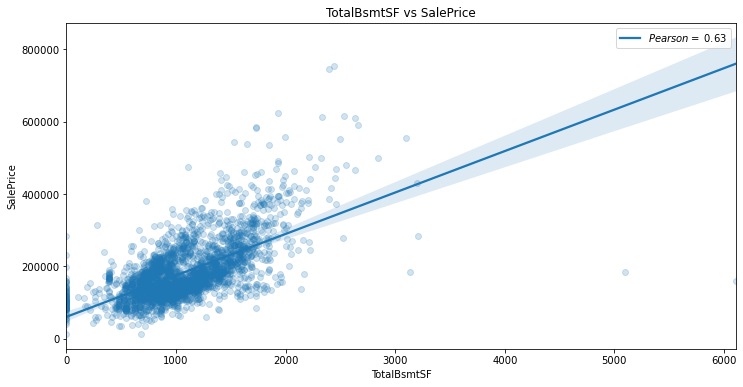

In [10]:
Pearson_TBSF = 0.63
plt.figure(figsize = (12,6))
sns.regplot(data=data_w, x = 'TotalBsmtSF', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('TotalBsmtSF vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_TBSF)], loc = 'best')
plt.show()

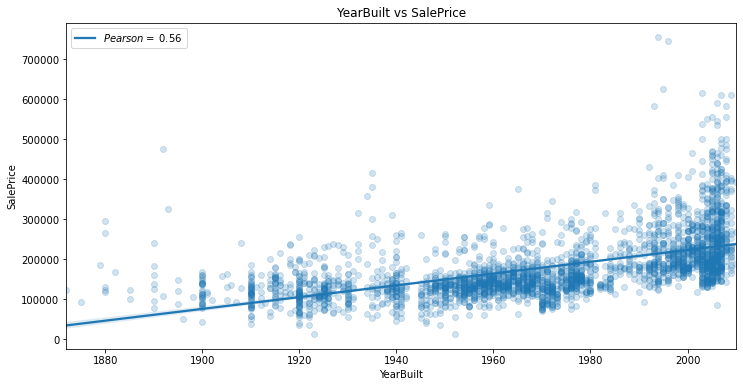

In [11]:
# YearBuilt vs SalePrice

Pearson_YrBlt = 0.56
plt.figure(figsize = (12,6))
sns.regplot(data=data_w, x = 'YearBuilt', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('YearBuilt vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_YrBlt)], loc = 'best')
plt.show()

In [ ]:
# Median of Sale Price by Year

plt.figure(figsize = (10,5))
sns.barplot(x='YrSold', y="SalePrice", data = data_w, estimator = np.median)
plt.title('Median of Sale Price by Year', fontsize = 13)
plt.xlabel('Selling Year', fontsize = 12)
plt.ylabel('Median of Price in $', fontsize = 12)
plt.show()

###  DATA PREPROCESSING

Now that we have some insights about data, we need to preprocess them for the modeling part. The main steps are:

- Looking at potential NaN
- Dealing with categorical features (e.g. Dummy coding)
- Normalization

N.B:

Usually, in a real-world project, the test data are not available until the end. For this reason, test data should contain the same type of data of the training set to preprocess them in the same way. Here, the test set is available. It contains some observations not present in the training dataset and,the use of dummy coding could raise several issues (I spent a lot of time figuring out why I was not able to make predictions on the test set). The easiest way to solve this problem (that is not applicable if test data are not available) is to concatenate Train and Test sets, preprocess, and divide them again.


In [ ]:
# Separating Target and Features

target = data_w['SalePrice']
test_id = test['Id']
test = test.drop(['Id'],axis = 1)
data_w2 = data_w.drop(['SalePrice','Order','PID'], axis = 1)


# Concatenating train & test set

train_test = pd.concat([data_w2,test], axis=0, sort=False)

In [ ]:
# Looking at NaN % within the data

nan = pd.DataFrame(train_test.isna().sum(), columns = ['NaN_sum'])
nan['feat'] = nan.index
nan['Perc(%)'] = (nan['NaN_sum']/1460)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan['Usability'] = np.where(nan['Perc(%)'] > 20, 'Discard', 'Keep')
nan

In [ ]:
# Plotting Nan

plt.figure(figsize = (15,5))
sns.barplot(x = nan['feat'], y = nan['Perc(%)'])
plt.xticks(rotation=45)
plt.title('Features containing Nan')
plt.xlabel('Features')
plt.ylabel('% of Missing Data')
plt.show()

Are we sure that all these nans are real missing values? Looking at the given description file, we can see how the majority of these nans reflect the absence of something, and for this reason, they are not nans. We can impute them (for numerical features) or substitute them with data in the file:

In [ ]:
# Converting non-numeric predictors stored as numbers into string

train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['YrSold'] = train_test['YrSold'].apply(str)
train_test['MoSold'] = train_test['MoSold'].apply(str)

# Filling Categorical NaN (That we know how to fill due to the description file )

train_test['Functional'] = train_test['Functional'].fillna('Typ')
train_test['Electrical'] = train_test['Electrical'].fillna("SBrkr")
train_test['KitchenQual'] = train_test['KitchenQual'].fillna("TA")
train_test['Exterior1st'] = train_test['Exterior1st'].fillna(train_test['Exterior1st'].mode()[0])
train_test['Exterior2nd'] = train_test['Exterior2nd'].fillna(train_test['Exterior2nd'].mode()[0])
train_test['SaleType'] = train_test['SaleType'].fillna(train_test['SaleType'].mode()[0])
train_test["PoolQC"] = train_test["PoolQC"].fillna("None")
train_test["Alley"] = train_test["Alley"].fillna("None")
train_test['FireplaceQu'] = train_test['FireplaceQu'].fillna("None")
train_test['Fence'] = train_test['Fence'].fillna("None")
train_test['MiscFeature'] = train_test['MiscFeature'].fillna("None")

for col in ('GarageArea', 'GarageCars'):
    train_test[col] = train_test[col].fillna(0)
        
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train_test[col] = train_test[col].fillna('None')
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train_test[col] = train_test[col].fillna('None')
    
    # Checking the features with NaN remained out

for col in train_test:
    if train_test[col].isna().sum() > 0:
        print(train_test[col][0])

In [ ]:
useless = ['GarageYrBlt','YearRemodAdd'] #,'BsmtHalfBath'
train_test = train_test.drop(useless, axis = 1)

# Imputing with KnnRegressor

def impute_knn(df):
    ttn = train_test.select_dtypes(include=[np.number])
    ttc = train_test.select_dtypes(exclude=[np.number])

    cols_nan = ttn.columns[ttn.isna().any()].tolist()         # columns w/ nan 
    cols_no_nan = ttn.columns.difference(cols_nan).values     # columns w/n nan

    for col in cols_nan:
        imp_test = ttn[ttn[col].isna()]   # indicies which have missing data will become our test set
        imp_train = ttn.dropna()          # all indicies which which have no missing data 
        model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ttn.loc[ttn[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
    return pd.concat([ttn,ttc],axis=1)

train_test = impute_knn(train_test)


objects = []
for i in train_test.columns:
    if train_test[i].dtype == object:
        objects.append(i)
train_test.update(train_test[objects].fillna('None'))

# # Checking NaN presence

for col in train_test:
    if train_test[col].isna().sum() > 0:
        print(train_test[col][0])

### FEATURE ENGINEERING

Let's create some new features combining the ones that we already have. These could help us to increase the performance of the model!

In [ ]:
train_test["SqFtPerRoom"] = train_test["GrLivArea"] / (train_test["TotRmsAbvGrd"] +
                                                       train_test["FullBath"] +
                                                       train_test["HalfBath"] +
                                                       train_test["KitchenAbvGr"])

train_test['Total_Home_Quality'] = train_test['OverallQual'] + train_test['OverallCond']

train_test['Total_Bathrooms'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) +
                               train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))

train_test["HighQualSF"] = train_test["1stFlrSF"] + train_test["2ndFlrSF"]

# Converting non-numeric predictors stored as numbers into string

train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['YrSold'] = train_test['YrSold'].apply(str)
train_test['MoSold'] = train_test['MoSold'].apply(str)

# Creating dummy variables from categorical features

train_test_dummy = pd.get_dummies(train_test)

# Fetch all numeric features

#train_test['Id'] = train_test['Id'].apply(str)
numeric_features = train_test_dummy.dtypes[train_test_dummy.dtypes != object].index
skewed_features = train_test_dummy[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index

# Normalize skewed features using log_transformation
    
for i in skew_index:
    train_test_dummy[i] = np.log1p(train_test_dummy[i])

Now let's try to tranform our target distribution into a normal one. To do this we use a log transformation. We will use qq-plot to see if the transformation will have the desired output.  

In [ ]:
# SalePrice before transformation

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(target, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])

sns.distplot(target, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

In [ ]:
target_log = np.log1p(target)

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(target_log, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(target_log, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

### MODELING

In [ ]:
train = train_test_dummy[0:2930]
test = train_test_dummy[2930:]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, target_log, test_size=0.3)

# Улучшить предсказания

- Выбрать другую модель (RandomForest, GradienBoosting, LinearRegression)
- Улучшить нынешнюю модель (подобрать оптимальные параметры модели)
- Композиция (-)

## Выбор другой модели

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
rfr_model = RandomForestRegressor()
gbr_model = GradientBoostingRegressor()
lr_model = LinearRegression()
xgr_model = XGBRegressor()

rfr_model.fit(X_train, y_train)
gbr_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)
xgr_model.fit(X_train, y_train)

print('MSE RFR:', mean_squared_error(rfr_model.predict(X_test), y_test))
print('MSE GBR:', mean_squared_error(gbr_model.predict(X_test), y_test))
print('MSE LR:', mean_squared_error(lr_model.predict(X_test), y_test))
print('MSE XGBR:', mean_squared_error(xgr_model.predict(X_test), y_test))

In [ ]:
# GradienBoosting - лучшее
best_model = gbr_model

## Улучшение модели

In [ ]:
base_model = GradientBoostingRegressor()
base_model.get_params()

#### Подбор параметров вручную

In [ ]:
n_estimators_list = [100, 200, 300, 400, 500]
scores = []

for i in range(len(n_estimators_list)):
    n_estimators = n_estimators_list[i]
    
    base_model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=42)
    base_model.fit(X_train, y_train)
    mse = mean_squared_error(base_model.predict(X_test), y_test)
    scores.append(mse)


In [ ]:
scores

In [ ]:
opt_n_estimators = 500

### SUBMISSION

In [ ]:
# Test CSV Submission

test_pred = best_model.predict(test)
submission = pd.DataFrame(test_id, columns = ['Id'])
submission['Id'] = test_id
test_pred = np.expm1(test_pred)#.round()
submission['SalePrice'] = test_pred 
submission.head()

In [ ]:
# Saving the results in a csv file

submission.to_csv("result.csv", index = False, header = True)